## Introduction
In this notebook we will preprocess the data for our classification task.<br />
We will train a classifier to predict whether an X-Ray of a patient shows signs of pneumonia or not based on the RSNA Pneumonia Detection Challenge (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge).

At first we download the data from kaggle (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data), by clicking on "Download All" and extract it afterwards.

Acknowledgements:
Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

Original Source: https://nihcc.app.box.com/v/ChestXray-NIHCC

## Imports
* pathlib for convenient path handling
* pydicom for reading dicom files
* numpy for storing the actual images
* cv2 for directly resizing the images
* pandas to read the provided labels
* matplotlib for visualizing some images
* tqdm for nice progress bar

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
root = "/content/drive/My Drive/pytorch_udemy/04-Pneumonia-Classification/data/"

In [3]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 12.6 MB/s 


In [4]:
!pip install -Uqq ipdb

     |████████████████████████████████| 793 kB 11.6 MB/s 
     |████████████████████████████████| 381 kB 58.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.29 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.34.0 which is incompatible.


In [5]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import glob
import ipdb
import numpy as np

In [6]:
%pdb = on

Incorrect argument. Use on/1, off/0, or nothing for a toggle.


At first, we read the csv file containing the labels

In [7]:
labels = pd.read_csv(root + "stage_2_train_labels.csv")

In [8]:
labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


Note that subjects may occur multiple times in the dataset because different pneumonia spots are handled indivually. For our classification task, we can remove those duplicates as we are only interested in the binary label.

In [9]:
# Remove duplicate entries
labels = labels.drop_duplicates("patientId")

In [10]:
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


Let's define the path to the dicom files and also the path were we want to store our processed npy files

In [11]:
ROOT_PATH = Path(root + "/stage_2_train_images/")
SAVE_PATH = Path(root + "Processed/")
print(SAVE_PATH)

/content/drive/My Drive/pytorch_udemy/04-Pneumonia-Classification/data/Processed


Let's look at some example images

/content/drive/My Drive/pytorch_udemy/04-Pneumonia-Classification/data/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm
/content/drive/My Drive/pytorch_udemy/04-Pneumonia-Classification/data/stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm
/content/drive/My Drive/pytorch_udemy/04-Pneumonia-Classification/data/stage_2_train_images/00322d4d-1c29-4943-afc9-b6754be640eb.dcm
/content/drive/My Drive/pytorch_udemy/04-Pneumonia-Classification/data/stage_2_train_images/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm
/content/drive/My Drive/pytorch_udemy/04-Pneumonia-Classification/data/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm
/content/drive/My Drive/pytorch_udemy/04-Pneumonia-Classification/data/stage_2_train_images/00569f44-917d-4c86-a842-81832af98c30.dcm
/content/drive/My Drive/pytorch_udemy/04-Pneumonia-Classification/data/stage_2_train_images/006cec2e-6ce2-4549-bffa-eadfcd1e9970.dcm
/content/drive/My Drive/pytorch_udemy/04-Pneumonia-Classification/dat

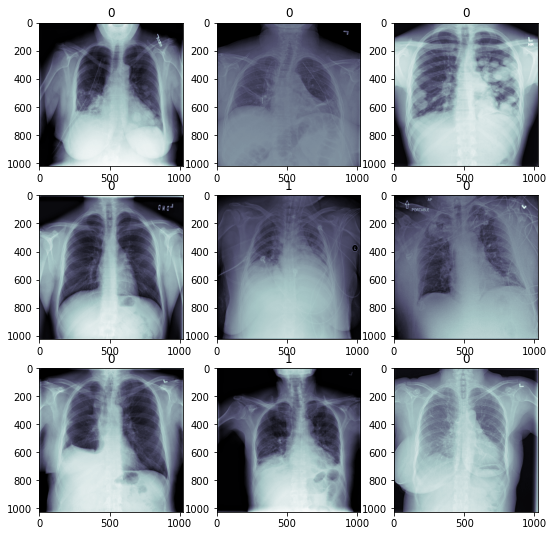

In [15]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))
c = 0
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        print(dcm_path)
        dcm = pydicom.read_file(dcm_path).pixel_array
        
        label = labels["Target"].iloc[c]
        
        axis[i][j].imshow(dcm, cmap="bone")
        axis[i][j].set_title(label)
        c+=1

## Dicom Reading & Effective storage

In order to efficiently handle our data in the Dataloader, we convert the X-Ray images stored in the DICOM format to numpy arrays. Afterwards we compute the overall mean and standard deviation of the pixels of the whole dataset, for the purpose of normalization.
Then the created numpy images are stored in two separate folders according to their binary label:
* 0: All X-Rays which do not show signs of pneumonia
* 1: All X-Rays which show signs of pneumonia

To do so, we iterate over the patient ids and concat the patient ID with the ROOT_PATH.

We then directly save the standardized and resized files into the corresponding directory (0 for healthy, 1 for pneumonia).
This allows to take advantage of the ready-to-use torchvision **DatasetFolder** for simple file reading


We standardize all images by the maximum pixel value in the provided dataset, 255.
All images are resized to 224x224.

To compute dataset mean and standard deviation, we compute the sum of the pixel values as well as the sum of the squared pixel values for each subject.
This allows to compute the overall mean and standard deviation without keeping the whole dataset in memory.


In [16]:
lentrain = len(os.listdir(ROOT_PATH))

In [17]:
lentrain

26313

In [18]:
lentest = len(os.listdir(root + "/stage_2_test_images/"))

In [ ]:
import os
sums = 0
sums_squared = 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
    dcm_path = ROOT_PATH/patient_id  # Create the path to the dcm file
    dcm_path = dcm_path.with_suffix(".dcm")  # And add the .dcm suffix

 #   if not os.path.isdir(dcm_path):
  #    print("I do not have this file")
    # Read the dicom file with pydicom and standardize the array
    if os.path.exists(dcm_path):
      dcm = pydicom.read_file(dcm_path).pixel_array / 255  
          
      # Resize the image as 1024x1024 is way to large to be handeled by Deep Learning models at the moment
      # Let's use a shape of 224x224
      # In order to use less space when storing the image we convert it to float16
      dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)
      
      # Retrieve the corresponding label
      label = labels.Target.iloc[c]
      
      # 4/5 train split, 1/5 val split
      train_or_val = "train" if c < lentrain else "val" 
          
      current_save_path = SAVE_PATH/train_or_val/str(label) # Define save path and create if necessary
      current_save_path.mkdir(parents=True, exist_ok=True)
      np.save(current_save_path/patient_id, dcm_array)  # Save the array in the corresponding directory
      
      normalizer = dcm_array.shape[0] * dcm_array.shape[1]  # Normalize sum of image
      if train_or_val == "train":  # Only use train data to compute dataset statistics
          sums += np.sum(dcm_array) / normalizer
          sums_squared += (np.power(dcm_array, 2).sum()) / normalizer




In [ ]:
while True:pass

In [ ]:
print(len(os.listdir(root + "Processed/train/0")))

1865


In [ ]:
print(len(os.listdir(root + "Processed/train/1")))

757


In [ ]:
train_processed = os.path.join(SAVE_PATH,"train/0/")
print(train_processed)

/content/drive/My Drive/pytorch_udemy/04-Pneumonia-Classification/data/Processed/train/0/


In [ ]:
import os
sums = 0
sums_squared = 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
    dcm_path = ROOT_PATH/patient_id  # Create the path to the dcm file
    dcm_path = dcm_path.with_suffix(".dcm")  # And add the .dcm suffix

 #   if not os.path.isdir(dcm_path):
  #    print("I do not have this file")
    # Read the dicom file with pydicom and standardize the array
    if os.path.exists(dcm_path):
      dcm = pydicom.read_file(dcm_path).pixel_array / 255  
          
      # Resize the image as 1024x1024 is way to large to be handeled by Deep Learning models at the moment
      # Let's use a shape of 224x224
      # In order to use less space when storing the image we convert it to float16
      dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)
      
      # Retrieve the corresponding label
      label = labels.Target.iloc[c]
      
      # 4/5 train split, 1/5 val split
      train_or_val = "train" if c < lentrain else "val" 
      
      normalizer = dcm_array.shape[0] * dcm_array.shape[1]  # Normalize sum of image
      if train_or_val == "train":  # Only use train data to compute dataset statistics
          sums += np.sum(dcm_array) / normalizer
          sums_squared += (np.power(dcm_array, 2).sum()) / normalizer


  0%|          | 0/30227 [00:00<?, ?it/s]

In [27]:
for files, subfolders in os.walk("/content/drive/My Drive/pytorch_udemy/04-Pneumonia-Classification/data/Processed/train/**/*.npy"):
  print(len(files))


In [31]:
sums = 0
sums_squared = 0

for files in glob.glob("/content/drive/My Drive/pytorch_udemy/04-Pneumonia-Classification/data/Processed/train/**/*.npy"):
  dcm_array = np.load(files)
  # Create the path to the dcm file
  normalizer = dcm_array.shape[0] * dcm_array.shape[1]  # Normalize sum of image
  sums += np.sum(dcm_array) / normalizer
  sums_squared += (np.power(dcm_array, 2).sum()) / normalizer
 
  


In [32]:
sums


12719.316087372456

In [33]:
sums_squared

7831.9741509884925

In [34]:
mean = sums / lentrain
std = np.sqrt(sums_squared / lentrain - (mean**2))

We will use mean and std later in the dataloader to normalize our data

In [35]:
print(f"Mean of Dataset: {mean}, STD: {std}")

Mean of Dataset: 0.48338525015666994, STD: 0.2529530948709135
